# Implement a Markov Chain Monte Carlo sampling

In this tutorial, it will be shown how to implement a simple MCMC sampler from scratch.

This is just an educational example, whose goal is to showcase the simplicity of the base idea.

For a production-ready sampler, further complications have to be taken into account, including:
- algorithm improvements
- performance of the implementation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from matplotlib import cm

%matplotlib widget

## Distribution

We will use as an example a simple Gaussian mixture.

Sampling from a Gaussian mixture is pretty simple on its own, since you can just do it hierarchically:
1. sample from which Gaussian we should pick our sample, $Categorical(k)$
2. sample from the chosen Gaussian, $Gaussian(\mu_i, \sigma_i)$

However, we will use this as a **test case** to implement a *Markov Chain Monte Carlo*, adopting the *Metropolis algorithm*.

In [2]:
PARAMETERS = dict(
    gaussians=[
        dict(mean=np.array([-2, -2]), cov=np.eye(2) * 2),
        dict(mean=np.array([1, 2]), cov=np.eye(2) * 3),
    ],
    weights=np.array([0.55, 0.45]),
)


def gaussian_mixture(x):
    return (
        np.array(
            [
                scipy.stats.multivariate_normal.pdf(x, **pars)
                for pars in PARAMETERS["gaussians"]
            ]
        ).T
        @ PARAMETERS["weights"]
    ).T

### Visualization

Let's visualize the distribution we have just defined.

Of course, this is possible because we are sampling a two dimensional distribution, and we already know which is the area of interest, where most of the volume and the features of the distribution are located.
However, MCMC samplers are *especially useful in high dimension and* for distributions often *implicitly defined*. In the first case because most of the other sampling methods become exponentially expensive, and the second because we might know very little analytically about the distribution we want to sample.

A feature of the Metropolis algorithm is to **only depend on probability ratios**. We will dive into the Metropolis algorithm later on, but notice that this feature is incredibly useful for *unnormalized* distributions, e.g. including:
- lattice field theory distributions, defined by a *path integral* (hardly normalizable analytically)
- distributions defined as a *product* of other distributions
   - as those arising in *Bayesian statistics*, where computing the *evidence* is the main obstacle

In [3]:
from matplotlib.axis import Axis
from matplotlib.figure import Figure

HWIDTH = 5  # half-width
POINTS = 100  # number of points per side


# create the grid
def surface(function, hwidth: float, points: int):
    x = np.linspace(-hwidth, hwidth, points)
    y = np.linspace(-hwidth, hwidth, points)
    xx, yy = np.meshgrid(x, y)
    coords = np.transpose(np.stack([xx, yy]), axes=(1, 2, 0))
    zz = function(coords)

    return xx, yy, zz


def countor(xx, yy, zz, ax: Axis):
    ax.contourf(xx, yy, zz, cmap=cm.coolwarm)
    ax.set_xlim(-HWIDTH, HWIDTH)
    ax.set_ylim(-HWIDTH, HWIDTH)


def plot_distribution(xx, yy, zz, fig: Figure):
    axsurf = fig.add_subplot(1, 2, 1, projection="3d")
    surf = axsurf.plot_surface(
        xx, yy, zz, cmap=cm.coolwarm, linewidth=0, antialiased=False
    )

    axcont = fig.add_subplot(1, 2, 2)
    countor(xx, yy, zz, axcont)

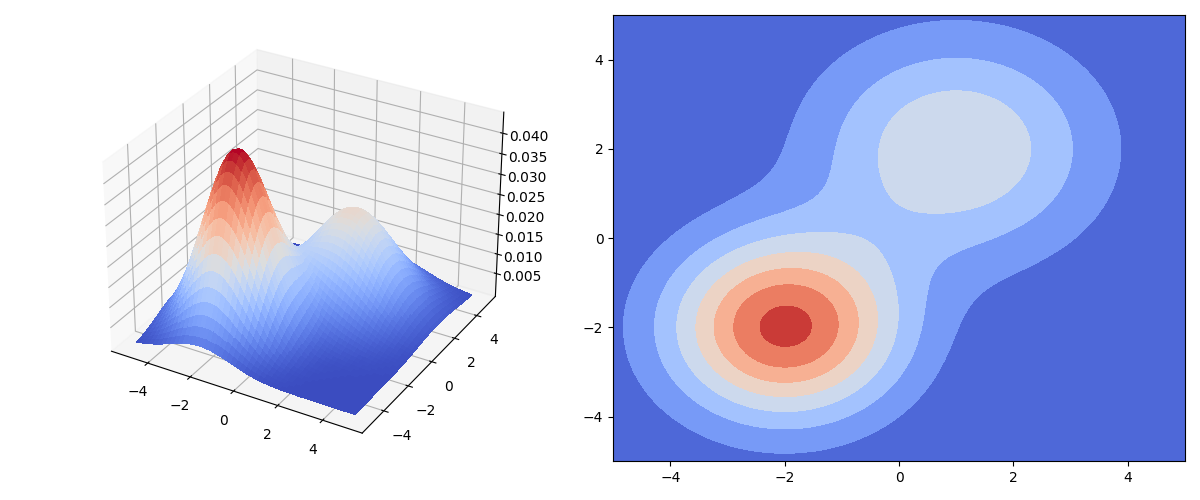

In [4]:
# side note: some niceties of using Jupyter Notebooks
#
# Jupyter works with a global environment, as a whatever Python script, but you
# are inside an interpreter, so the environment is kept for all cell runs, and
# multiple executions of the same cells overwrite the global scope
# combined with matplotlib (and its plugin) usage of globals -> we need to close
# "windows" before plotting on new figures, to display it properly
plt.close()
fig = plt.figure("Gaussian mixture", figsize=(12, 5), layout="tight")
plot_distribution(*surface(gaussian_mixture, HWIDTH, POINTS), fig=fig)

Let's also add some sanity checks, *computing numerically the normalization*.

Remember that also **quadrature integration** is only possible because of the **limited dimensionality**. For higher dimensional distributions, we would need Monte Carlo integration as well, a close analogue of what we are about to do.

In [5]:
def gm_normalization(hintw: float) -> float:
    """Compute gaussian mixture normalization, given half integration range width"""
    return scipy.integrate.dblquad(
        lambda x, y: gaussian_mixture([x, y]),
        -hintw,
        hintw,
        lambda _x: -hintw,
        lambda _x: hintw,
    )


def norm_display(norm: float, err: float) -> str:
    return f"""
normalization: {norm}
missing: {1 - norm}
integration error: {err}
relative missing: {(1-norm)/err}
"""


for hintw in (5, 8, 11):
    print(f"\thalf-width: {hintw}")
    print(norm_display(*gm_normalization(hintw)))

	half-width: 5

normalization: 0.958143014146753
missing: 0.04185698585324704
integration error: 1.4839377024696581e-08
relative missing: 2820670.017588079

	half-width: 8

normalization: 0.9998561524330668
missing: 0.00014384756693319734
integration error: 1.4096981197815606e-08
relative missing: 10204.13980232074

	half-width: 11

normalization: 0.9999999523665027
missing: 4.7633497257670854e-08
integration error: 1.4124507600197025e-08
relative missing: 3.3724005541266733



## Metropolis MCMC

Here we will develop ***our own implementation*** of a Markov Chain Monte Carlo (MCMC) based on the [Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm).

A generic MCMC is just a discrete time process $x_t$, generated extracting from transition probability $P(x' | x)$, i.e. a probability distribution for the next extraction, based only on the current state.
This is the crucial property of a Markov-chain: being memory-less.

The essential ingredients for a MCMC to eventually sample a *target distribution* $\pi(x)$ are:
1. ergodicity
2. solving the *detailed balance*

### Ergodicity

Ergodicity is a bit technical, but essentially can be summarized with:
- the chain should be able to reach every region of the domain
- the chain is not periodically oscillating among some states

For a more accurate definiton, just read the [Ergodicity](https://en.wikipedia.org/wiki/Markov_chain#Ergodicity) section on Wikipedia.

The idea is the chain should be able to **freely explore the domain**, and its behavior should be eventually dictated by the target distribution, so the transition probability $P(x' | x)$ has to be *flexible enough*.

We will ensure this requirement to be satisfied by choosing a transition probability able to potentially *jump wherever in our domain*, just with an arbitrarily small probability.

### Detailed balance

It is a sufficient (but not strictly necessary) condition for the chain, that encodes in the process the information about the target distribution.

The formal expression is:
$$
P(x' | x) \pi(x) = P(x | x') \pi(x')
$$

It is usually very helpful to visualize as a ratio:
$$
\frac{P(x' | x)}{P(x | x')} = \frac{\pi(x')}{\pi(x)}
$$
that reads:
> *the ratio of the probability of jumping to $x'$ from $x$ and the inverse jump is equal to the probabilities ratio in the target distribution*.

And the gist of the chain sampling property proof is the clearest tool to understand this property:
- consider starting with an ensemble of walkers already distributed according to $\pi$
- take one step with $P(x' | x)$ for each of them
- the distribution of the walkers in the next step will be unchanged, since the detailed balance is telling us that the numbers of walkers jumping from one state to another and the opposite **exactly compensate**

(In principle, satisfying the *integrated* [balance equation](https://en.wikipedia.org/wiki/Balance_equation) is sufficient and necessary, but it is usually harder to prove, so the detailed balance is usually used as a stronger but simpler condition)

### Assumptions roles

So the detailed balance is giving us the stability for $\pi$ in our chain $x_t$. Leveraging ergodicity is possible to prove also the convergence.

---

A proof of the Markov Chain convergence theorem is textbook material, e.g. it can be found in chapter 5 of

> Häggström, O. (2002). Finite Markov Chains and Algorithmic Applications (London Mathematical Society Student Texts). Cambridge: Cambridge University Press. [doi:10.1017/CBO9780511613586](https://doi.org/10.1017/CBO9780511613586)

I am still looking for an official reference, even though I suspect to be the one reported [by Wikipedia](https://en.wikipedia.org/wiki/Discrete-time_Markov_chain#References):

> A. A. Markov (1907). "Extension of the limit theorems of probability theory to a sum of variables connected in a chain"

If anyone is able to find it or confirm, please tell me :)

## Random numbers

First of all, since we are going to play with some random numbers, let's immediately grab a generator:

In [6]:
rng = np.random.default_rng(seed=42)

rng.standard_normal()

0.30471707975443135

Note that is always a good practice to **fix a seed**.

Our generator is actually a pseudo-random number generator (PRNG), so the generated sequence is seemingly random, with good statistical and numerical properties, but it has to be perfectly reproducible.

# Metropolis algorithm

The Metropolis algorithm is just a way to define a suitable transition probability for a given target distribution.

It separates the problem in two halves:
1. start from an already ergodic **proposal distribution** $g(x' | x)$
    - the basic flavor of the algorithm requires it to be also *symmetric* $g(x' | x) = g(x | x')$
2. adjust it with an **accept-reject** mechanism, to impose the detailed balance

The exact algorithm is the following:

0. initialize the chain at an arbitrary $x_0$
1. at each time $t$, a candidate $x'$ is draw from the proposal $g(x_{t+1} | x_t)$
2. a probability ratio $\alpha = \pi(x') / \pi(x_t)$ is computed, and a random variable $u \sim U[0, 1]$ is drawn
    - if $u \leq \alpha$ the candidate is **accepted**, $x_{t+1} = x'$
    - if $u > \alpha$ the candidate is **rejected**, $x_{t+1} = x_t$

The resulting chain is not necessarily optimal, but this approach is sufficiently generic to be a good enough sampler in a high-dimensional space, where a lot of other samplers quickly deteriorate (even though there are more efficient specialized versions).

The path to optimize the algorithm is to improve the proposal choice:
- it should move fast enough to sample the whole relevant domain almost independently
- but close enough to the target distribution, in order to accept more frequently ($\alpha(x, x') \sim 1$ for most extractions)

With these properties the chain would develop a *fast convergence* and a *low self-correlation*.

### Metropolis-Hastings

This is a simple generalization to a non-symmetric proposal. Simply, the relevant ratio is corrected by the proposal:
$$
\alpha = \frac{\pi(x')}{\pi(x)} \frac{g(x, x')}{g(x', x)}
$$

In [7]:
# type synonim for a point in our space
# a more correct type would be npt.NDArray[float]
Point = np.ndarray

### Proposal distribution

We will adopt a very simple proposal, with a unique further property: **locality**.

This is *not a strict requirement* for our generator, but it is a sensible one for sampling most distributions: our proposal will have most of the weight in a neighborhood of the current position.
This will help us, since once our chain will have found the bulk of the distribution, it will likely keep sampling from it, with some rare detours to the tails. As it should.

However, our proposal will be non-zero on the whole domain, irrespective of the current point $x$. This ensures ergodicity.

In [8]:
def random_walk(point: Point, step: float = 1.0):
    return point + step * rng.standard_normal(size=2)

In [9]:
from typing import List


def flat(x):
    """A flat background"""
    return np.zeros_like(x[:, :, 0])


def walking_plot(samples: List[Point], ax: Axis, landscape=flat):
    """The landscape should be the intended distribution."""
    countor(*surface(landscape, hwidth=HWIDTH, points=POINTS), ax)
    xs = np.array(samples)
    ax.scatter(
        xs[:, 0], xs[:, 1], c=np.arange(xs.shape[0]), marker=".", cmap=cm.inferno
    )


def test_wp(landscape=True):
    xs = np.linspace(-HWIDTH + 1, HWIDTH - 1, 50)
    ys = np.sin(xs)
    samples = list(np.array([xs, ys]).T)

    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), clear=True, layout="tight")

    if landscape:
        walking_plot(samples, ax, gaussian_mixture)
    else:
        walking_plot(samples, ax)

### The chain

In [10]:
from itertools import islice
from typing import Callable, Iterator, List


def metropolis(
    distribution: Callable[[Point], float],
    proposal: Callable[[Point], Point],
    initial: Point,
) -> Iterator[Point]:
    point = initial
    while True:
        yield point
        candidate = proposal(point)
        prob_start = distribution(point)
        prob_cand = distribution(candidate)
        alpha = prob_cand / prob_start
        u = rng.uniform()
        if u <= alpha:
            point = candidate

In [11]:
p0 = np.array([0.0, 0.0])
chain = metropolis(gaussian_mixture, proposal=lambda p: random_walk(p, 0.2), initial=p0)
samples = list(islice(chain, 20000))

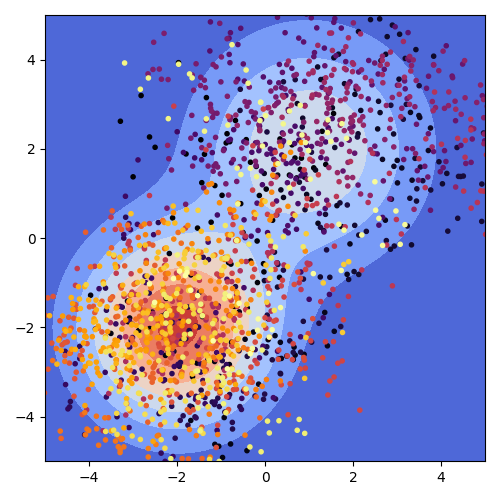

In [12]:
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(5, 5), num="Walker", clear=True, layout="tight")

walking_plot(samples[1000::10], landscape=gaussian_mixture, ax=ax)

We can have a look to a further slice, to see how the walkers move.

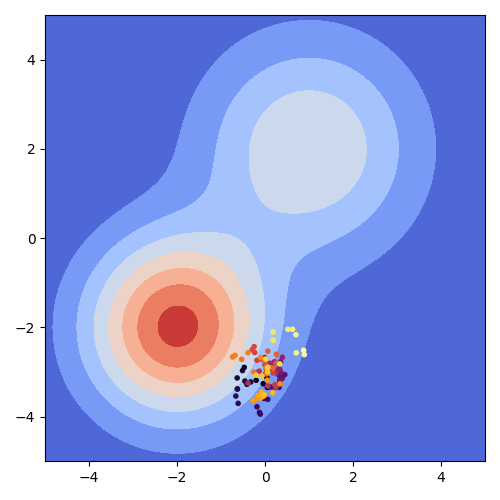

In [13]:
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(5, 5), num="Walker", clear=True, layout="tight")

walking_plot(list(islice(chain, 100)), ax=ax, landscape=gaussian_mixture)

## Speed up

MCMC runs are expensive, since there is a very well known rule in statistics telling that:
> N is never large
>
> https://statmodeling.stat.columbia.edu/2005/07/31/n_is_never_larg/

Consequently, you always need a longer run that what you can afford...

There are very smart techniques to improve the performance of the Metropolis algorithm, leveraging the properties of the target distribution, or general analytic tools.

One of the most successful technique is actually physics-inspired, and called Hamiltonian Monte Carlo (HMC). We will use it, but without going through its details, nor the implementation. It is directly implemented by various packages, and readily available to solve actual problems.

Here, we will try to speed up a bit the previous implementation, in order to extract more samples from our chain, and have a quick look at some of their properties.

In [14]:
import numba as nb

# not used, nor tested, but a more generic definition
@nb.njit
def multinorm(cov):
    return np.sqrt((2.0 * np.pi) ** len(cov) * np.linalg.det(cov))

# not used, nor tested, but a more generic definition
@nb.njit
def multigaussian(x, mu, weight, norm):
    shift = x - mu
    return np.exp(-shift @ weight @ shift / 2.0) / norm

# ---
# in practice we're only using isotropic Gaussians, i.e. with a covariance
# proportional to the identity
# we can leverage this to further simplify our implementation, and improve
# performances

# separate to avoid computing over and over
@nb.njit
def isomultinorm(factor, dim):
    return np.sqrt((2.0 * np.pi * factor) ** dim)


@nb.njit
def isomultigaussian(x, mu, weight, norm):
    shift = x - mu
    return np.exp(-np.sum(shift**2, axis=-1) * weight / 2.0) / norm


@nb.njit
def gaussian_mixture_(x):
    mean0 = np.array([-2.0, -2.0])
    cov0 = 2.0
    mean1 = np.array([1.0, 2.0])
    cov1 = 3.0
    return 0.55 * isomultigaussian(
        x, mean0, 1 / cov0, isomultinorm(cov0, 2)
    ) + 0.45 * isomultigaussian(x, mean1, 1 / cov1, isomultinorm(cov1, 2))


@nb.njit
def random_walk_(point):
    return point + 0.2 * np.random.standard_normal(size=2)


@nb.njit
def metropolis_(distribution, proposal, initial, nsamples):
    point = initial
    np.random.seed(42)
    
    samples = []

    for _ in range(nsamples):
        samples.append(point)
        
        candidate = proposal(point)
        prob_start = distribution(point)
        prob_cand = distribution(candidate)
        alpha = prob_cand / prob_start
        u = np.random.rand()
        if u <= alpha:
            point = candidate
    
    return samples

In [15]:
nsamples = metropolis_(gaussian_mixture_, random_walk_, p0, int(1e6))

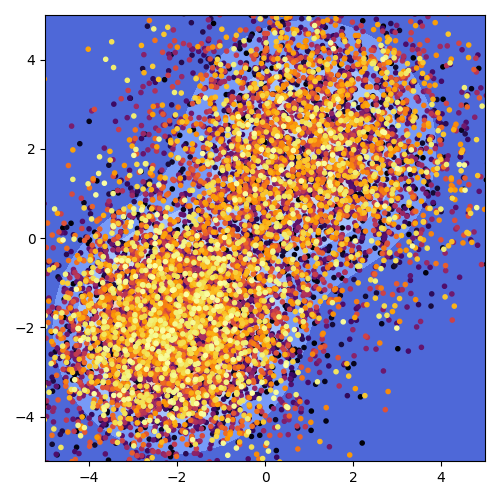

In [18]:
plt.close()
fig, ax = plt.subplots(
    1, 1, figsize=(5, 5), num="Numba Walker", clear=True, layout="tight"
)

walking_plot(nsamples[1000::100], landscape=gaussian_mixture_, ax=ax)

Following, we will compute the incremental averages (through the incredibly useful [NumPy's universal functions](https://numpy.org/doc/stable/reference/ufuncs.html)), and plot their evolution.

/tmp/ipykernel_422656/3250008101.py:1: RuntimeWarning: invalid value encountered in divide
  average = (np.add.accumulate(nsamples) / np.arange(len(nsamples))[:, np.newaxis])[1:]


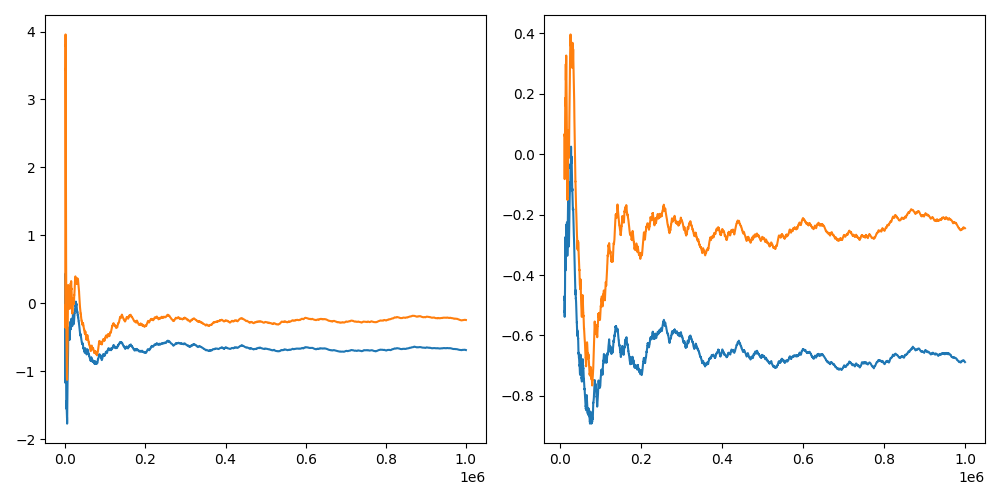

In [19]:
average = (np.add.accumulate(nsamples) / np.arange(len(nsamples))[:, np.newaxis])[1:]

plt.close()
fig, axs = plt.subplots(
    1, 2, figsize=(10, 5), num="Numba Average", clear=True, layout="tight"
)

axs[0].plot(average)
burn = 10000
axs[1].plot(np.arange(0, len(average)-burn) + burn, average[burn:]);

The right plot is just the magnified and cut version of the left one.

From the above plots, two distinctive features of MCMC are clearly shown:
- an initial *termalization* phase
    - in which the average is very different from its asymptotic value
- the *autocorellation* of the chain
    - two consequent values are not at all independent, and this is reflected in the damped oscillations
 
These properties are very important, since the final goal is to obtain independent samples.
They are described in some more details in chapter 3 of the [Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) book, and in any textbook on the subject.